In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Reading in the the dunking data.

# Initial exploratory analysis of the data

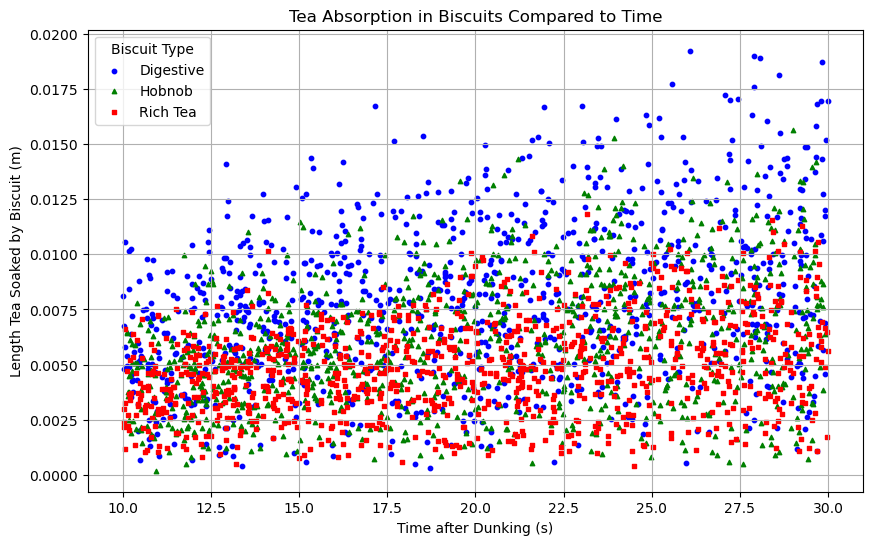

In [2]:
dunking_data = pd.read_csv('dunking-data.csv')


fig, ax = plt.subplots(figsize=(10, 6))


biscuit_types = dunking_data['biscuit'].unique()
colors = ['blue', 'green', 'red']  
markers = ['o', '^', 's']  


for biscuit, color, marker in zip(biscuit_types, colors, markers):
    subset = dunking_data[dunking_data['biscuit'] == biscuit]
    ax.scatter(subset['t'], subset['L'], color=color, marker=marker, s=10, label=biscuit)

ax.set_xlabel('Time after Dunking (s)')
ax.set_ylabel('Length Tea Soaked by Biscuit (m)')
ax.set_title('Tea Absorption in Biscuits Compared to Time')

ax.legend(title='Biscuit Type')

ax.grid(True)
plt.show()



Can't see much with time vs length
- Digestives seem to have a high variability in length although this could be due to the angle
- Rich teas seem to have the lowest absorption
- Hobnobs down the middle

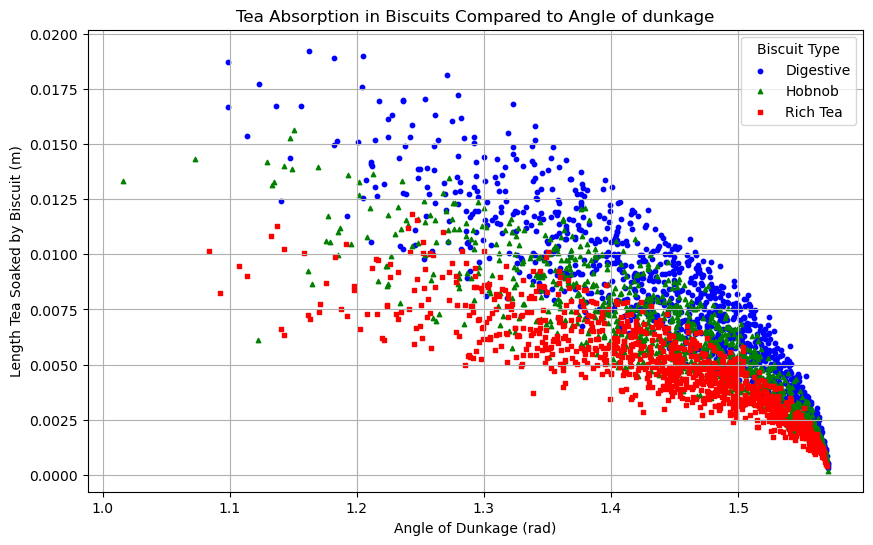

In [3]:



fig, ax = plt.subplots(figsize=(10, 6))


biscuit_types = dunking_data['biscuit'].unique()
colors = ['blue', 'green', 'red']  
markers = ['o', '^', 's']  


for biscuit, color, marker in zip(biscuit_types, colors, markers):
    subset = dunking_data[dunking_data['biscuit'] == biscuit]
    ax.scatter(subset['phi'], subset['L'], color=color, marker=marker, s=10, label=biscuit)

ax.set_xlabel('Angle of Dunkage (rad)')
ax.set_ylabel('Length Tea Soaked by Biscuit (m)')
ax.set_title('Tea Absorption in Biscuits Compared to Angle of dunkage')

ax.legend(title='Biscuit Type')

ax.grid(True)
plt.show()

All biscuit types are impacted by the angle of dunkage. Can see more clearly that digestives are, on the whole, more absorbent than hobnobs which are generally more absorbent than rich teas.

In [4]:
# Getting basic summary statistics of length grouped by biscuit type
summary_stats = dunking_data.groupby('biscuit')[["L"]].describe()

summary_stats


L                                                              \
            count      mean       std       min       25%       50%       75%   
biscuit                                                                         
Digestive  1000.0  0.007864  0.003604  0.000329  0.005221  0.007630  0.010143   
Hobnob     1000.0  0.006022  0.002861  0.000185  0.003891  0.005763  0.007842   
Rich Tea   1000.0  0.004843  0.002150  0.000392  0.003306  0.004721  0.006188   

                     
                max  
biscuit              
Digestive  0.019230  
Hobnob     0.015657  
Rich Tea   0.011808

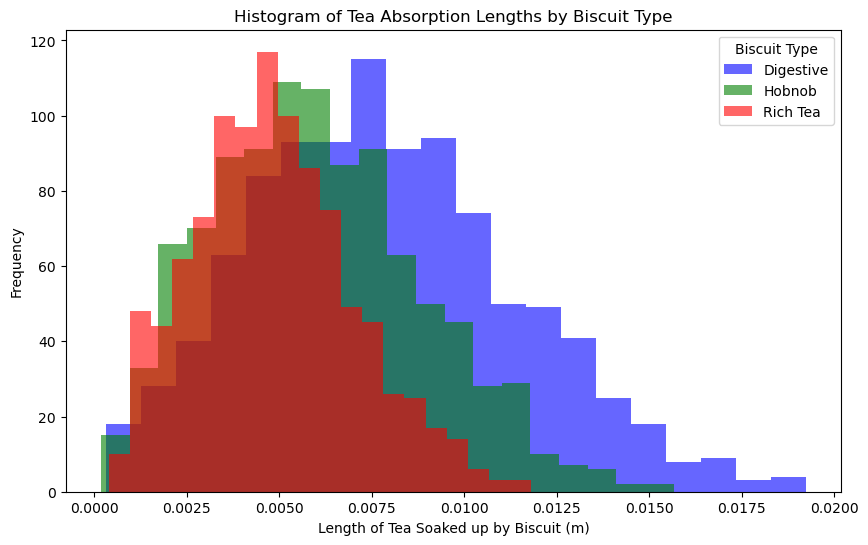

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

biscuit_types = dunking_data['biscuit'].unique()

colors = ['blue', 'green', 'red'] 

# Plotting histograms for each biccy type
for biscuit, color in zip(biscuit_types, colors):
    subset = dunking_data[dunking_data['biscuit'] == biscuit]
    ax.hist(subset['L'], bins=20, alpha=0.6, label=biscuit, color=color)

ax.set_xlabel('Length of Tea Soaked up by Biscuit (m)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Tea Absorption Lengths by Biscuit Type')
ax.legend(title='Biscuit Type')

# Show the plot
plt.show()

All data is normally distributed. Again can see tea travels further in digestives than hobnobs and hobnobs generally has tea travel further than rich teas.

Checking the shape of the dunking data

In [6]:

dunking_data.shape

(3000, 6)

Looking at the headings and top few rows of the dunking data to see what is there.

In [7]:
dunking_data.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


Checking for any null values

In [8]:
dunking_data.isnull().sum()

gamma      0
phi        0
eta        0
L          0
t          0
biscuit    0
dtype: int64

Removing the biscuit category so that the random forest model can be trained.

In [9]:
X = dunking_data[dunking_data.columns[:-1]]
X.head()

,gamma,phi,eta,L,t
0,0.073897,1.333006,0.000999,0.011196,19.362214
1,0.080946,1.476758,0.001012,0.005894,11.852589
2,0.087408,1.477141,0.000984,0.009249,24.793669
3,0.070793,1.502001,0.001002,0.003774,16.292780
4,0.058917,1.548274,0.001004,0.002291,13.662271


Scaling the data (X) so that each feature has a mean of 0 and variance of 1.

In [10]:
scaled_X = StandardScaler().fit_transform(X)
scaled_X

array([[ 0.06596114, -1.16247713, -0.1763231 ,  1.55578257, -0.08375485],
       [ 0.77413155,  0.35248485,  1.10014727, -0.10948028, -1.37661828],
       [ 1.42325581,  0.356527  , -1.66054277,  0.94409822,  0.85132923],
       ...,
       [-1.37764073,  0.01241775, -0.27264257,  0.42085499,  1.13891337],
       [-0.18625557, -2.43547144,  0.29222623,  2.43276913,  0.50332741],
       [ 0.95267679,  0.4117734 , -0.02025172, -0.74059162, -0.79724642]])

Create a list of the output parameter, the biscuit type, from the original input. Will contain in a variable called y.

In [11]:

y = dunking_data[dunking_data.columns[-1]]
y.head()

0    Digestive
1    Digestive
2    Digestive
3       Hobnob
4       Hobnob
Name: biscuit, dtype: object

The data has now been cleaned, scaled, and split into features and labels. Now it will be split into training and test data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, stratify=y, random_state=0)
X_train.shape, X_test.shape

((2250, 5), (750, 5))

The data has been split 3:1 training:test data. Stratify used above, ensures that we are dealing with classification, i.e. what type of each data point is.

Now the data has been split, we can use the Random Forest Classifier.

In [13]:
biscuit_classifier = RandomForestClassifier(random_state=0)
biscuit_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [14]:
y_pred_train = biscuit_classifier.predict(X_train)
training_accuracy = biscuit_classifier.score(X_train, y_train) * 100
print(f'Accuracy on training data: {training_accuracy:.1f} %')

Accuracy on training data: 100.0 %


The random forest model has 100% accuracy when predicting from the data it has already seen. Below we will see how the model predicts data that it hasn't seen before.

In [15]:
y_pred = biscuit_classifier.predict(X_test)
testing_accuracy = biscuit_classifier.score(X_test, y_test) * 100
print(f'Accuracy on testing data: {testing_accuracy:.1f} %')

Accuracy on testing data: 80.1 %


In this case, random forest has been better at predicting that random noise.

# Metrics and feature importance

We will look at some specific metrics using a classification report.

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Digestive       0.85      0.88      0.86       250
      Hobnob       0.72      0.69      0.70       250
    Rich Tea       0.83      0.84      0.83       250

    accuracy                           0.80       750
   macro avg       0.80      0.80      0.80       750
weighted avg       0.80      0.80      0.80       750





# Feature immportance from random forests


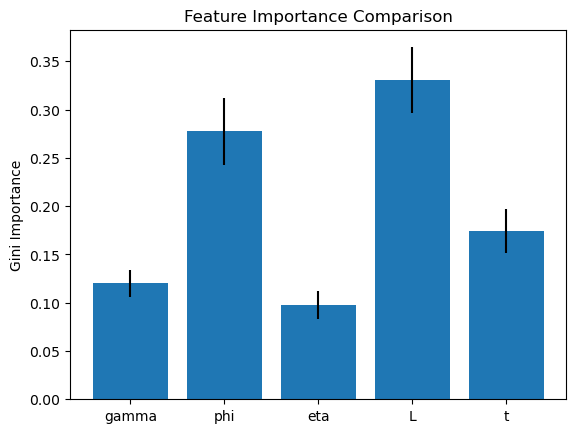

In [17]:
features_importances = biscuit_classifier.feature_importances_
features_importances_std = np.std([tree.feature_importances_ for tree in biscuit_classifier.estimators_], axis=0)

fig, ax = plt.subplots()
ax.bar(dunking_data.columns[:-1], features_importances, yerr=features_importances_std)
ax.set_ylabel('Gini Importance')
ax.set_xticks(ax.get_xticks())
ax.set_xticks(range(len(dunking_data.columns[:-1])))
ax.set_title('Feature Importance Comparison')
plt.show()

The most important parameters appear to be L (the distance up the biscuit the tea was visible) and phi (the contact angle between the biscuit and the tea surface). As the angle is controlled - is it L that is the best feature for identifying the biscuit?

In [18]:
micro_data = pd.read_csv('microscopy-data.csv')

micro_data['y_pred'] = pd.Series(y_pred)

In [19]:
micro_data

,gamma,phi,eta,L,t,r,y_pred
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,Rich Tea
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,Hobnob
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07,Rich Tea
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,Digestive
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,Rich Tea
...,...,...,...,...,...,...,...
495,0.077699,1.481847,0.000989,0.006078,21.967531,4.751893e-07,Rich Tea
496,0.067776,1.488293,0.001011,0.006595,18.163634,8.798032e-07,Hobnob
497,0.074166,1.554817,0.000997,0.003041,18.000978,8.652230e-07,Hobnob
498,0.081415,1.439910,0.001011,0.009119,19.136713,8.128785e-07,Digestive


Classifying the micrcoscopy data using the trained model

In [20]:
# removing pore size
untagged = pd.read_csv('microscopy-data.csv')
untagged = untagged.drop(['r'], axis=1)
scaled_X = StandardScaler().fit_transform(untagged)
y_pred = biscuit_classifier.predict(scaled_X)

micro_data = pd.read_csv('microscopy-data.csv')

micro_data['y_pred'] = pd.Series(y_pred)

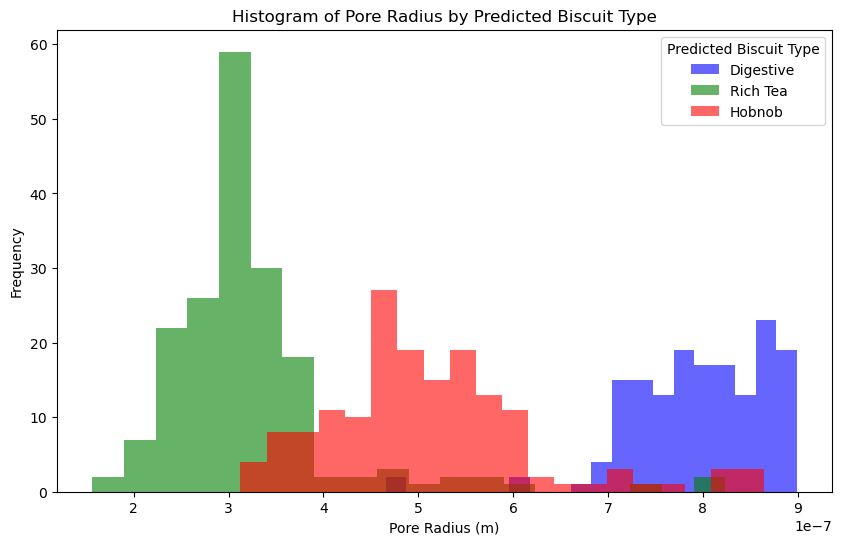

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

biscuit_types = micro_data['y_pred'].unique()

colors = ['blue', 'green', 'red'] 

# Plotting histograms for each biccy type
for biscuit, color in zip(biscuit_types, colors):
    subset = micro_data[micro_data['y_pred'] == biscuit]
    ax.hist(subset['r'], bins=20, alpha=0.6, label=biscuit, color=color)

ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Pore Radius by Predicted Biscuit Type')
ax.legend(title='Predicted Biscuit Type')

# Show the plot
plt.show()

Can see some clear groupings of the pore radius by projected biscuit type.

Now going to read in the timed data, add in the control variables to the dataframes and apply the random forest predictions to those data sets. they should hopefully show (for the most part) one biscuit type each as each trial is a different biscuit.

In [22]:
tr_1 = pd.read_csv('tr-1.csv')
tr_2 = pd.read_csv('tr-2.csv')
tr_3 = pd.read_csv('tr-3.csv')

tr_all = pd.concat([tr_1, tr_2, tr_3], axis = 0, ignore_index = True)

In [23]:
controls = ['gamma', 'phi', 'eta']
amounts = [0.0678, 1.45, 0.000993]

for control, amount in zip(controls, amounts):
    tr_all[control] = amount



In [24]:
tr_all_no_unc = tr_all.drop('dL', axis=1)
tr_all_no_unc

,t,L,gamma,phi,eta
0,30.000000,0.008087,0.0678,1.45,0.000993
1,32.727273,0.008253,0.0678,1.45,0.000993
2,35.454545,0.008607,0.0678,1.45,0.000993
3,38.181818,0.008920,0.0678,1.45,0.000993
4,40.909091,0.009604,0.0678,1.45,0.000993
...,...,...,...,...,...
295,289.090909,0.034766,0.0678,1.45,0.000993
296,291.818182,0.034769,0.0678,1.45,0.000993
297,294.545455,0.034655,0.0678,1.45,0.000993
298,297.272727,0.034646,0.0678,1.45,0.000993


In [25]:
tagged = pd.read_csv('dunking-data.csv')
X = tagged[tagged.columns[:-1]]
scaled_X = StandardScaler().fit_transform(X)
y = tagged[tagged.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, stratify=y, random_state=1)

biscuit_classifier = RandomForestClassifier(random_state=0)
biscuit_classifier.fit(X_train, y_train)
y_pred = biscuit_classifier.predict(X_test)
testing_accuracy = biscuit_classifier.score(X_test, y_test) * 100
print(f'Accuracy on testing data: {testing_accuracy:.1f} %')

print(classification_report(y_test, y_pred))

untagged = tr_all.drop('dL', axis=1)
scaled_X = StandardScaler().fit_transform(untagged)
y_pred = biscuit_classifier.predict(scaled_X)

Accuracy on testing data: 79.9 %
              precision    recall  f1-score   support

   Digestive       0.89      0.86      0.88       250
      Hobnob       0.71      0.73      0.72       250
    Rich Tea       0.80      0.80      0.80       250

    accuracy                           0.80       750
   macro avg       0.80      0.80      0.80       750
weighted avg       0.80      0.80      0.80       750



In [26]:
untagged['y_pred'] = pd.Series(y_pred)

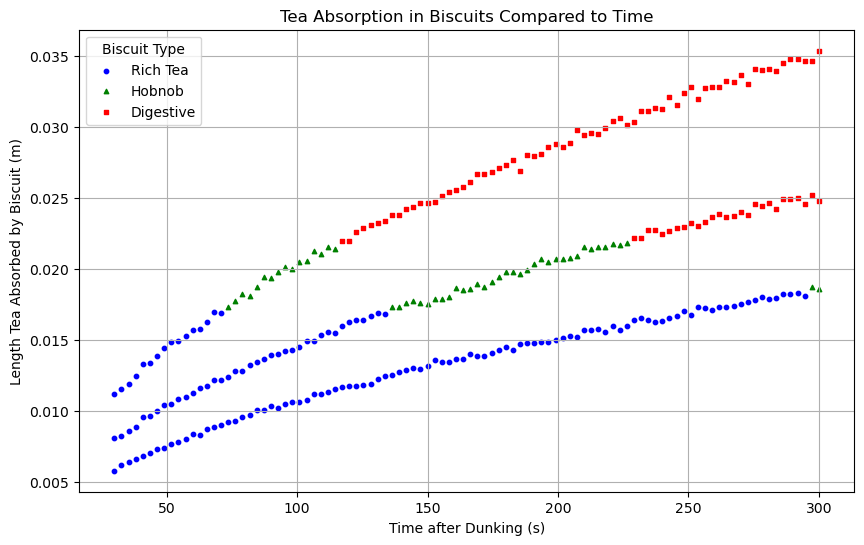

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))


biscuit_types = untagged['y_pred'].unique()
colors = ['blue', 'green', 'red']  
markers = ['o', '^', 's']  


for biscuit, color, marker in zip(biscuit_types, colors, markers):
    subset = untagged[untagged['y_pred'] == biscuit]
    ax.scatter(subset['t'], subset['L'], color=color, marker=marker, s=10, label=biscuit)

ax.set_xlabel('Time after Dunking (s)')
ax.set_ylabel('Length Tea Absorbed by Biscuit (m)')
ax.set_title('Tea Absorption in Biscuits Compared to Time')

ax.legend(title='Biscuit Type')

ax.grid(True)
plt.show()

The RF classifier doesn't appear to work with predicting the biscuit types based on time series data. Could be due to the time variatons in the RF methods only going up to 30s. It is mostly good at predicting rich teas, followed by digestives. Struggles to predict hobnobs, may be due to a lot of crossover between hobnobs and the other biscuits. 

# Going to try and estimate the pore radius on the big data using the Washburn equation


In [28]:
dunk_d = pd.read_csv('dunking-data.csv')
dunk_d['r'] = (2 * dunk_d['eta'] * dunk_d['L']**2) / (dunk_d['gamma'] * dunk_d['t'] * np.cos(dunk_d['phi']))

In [29]:
dunk_d

,gamma,phi,eta,L,t,biscuit,r
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,5.814437e-07
...,...,...,...,...,...,...,...
2995,0.084596,1.557367,0.000981,0.003221,24.231107,Digestive,7.396247e-07
2996,0.067928,1.487239,0.000993,0.003933,12.256570,Hobnob,4.421999e-07
2997,0.059526,1.444489,0.000998,0.007583,26.464108,Hobnob,5.781880e-07
2998,0.071386,1.212213,0.001004,0.013988,22.772293,Digestive,6.883535e-07


# Now training the model using the calculated r data

In [30]:
X = dunk_d.drop('biscuit', axis=1)
scaled_X = StandardScaler().fit_transform(X)

y = dunk_d[dunk_d.columns[-2]]

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, stratify=y, random_state=0)
X_train.shape, X_test.shape

((2250, 6), (750, 6))

In [31]:
biscuit_classifier = RandomForestClassifier(random_state=0)
biscuit_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [32]:
y_pred_train = biscuit_classifier.predict(X_train)
training_accuracy = biscuit_classifier.score(X_train, y_train) * 100
print(f'Accuracy on training data: {training_accuracy:.1f} %')

Accuracy on training data: 100.0 %


In [33]:
y_pred = biscuit_classifier.predict(X_test)
testing_accuracy = biscuit_classifier.score(X_test, y_test) * 100
print(f'Accuracy on testing data: {testing_accuracy:.1f} %')

Accuracy on testing data: 94.7 %


Adding in  radius has provided a significant improvement in classifying the biscuit types!

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Digestive       0.97      1.00      0.99       250
      Hobnob       0.96      0.88      0.92       250
    Rich Tea       0.91      0.96      0.94       250

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



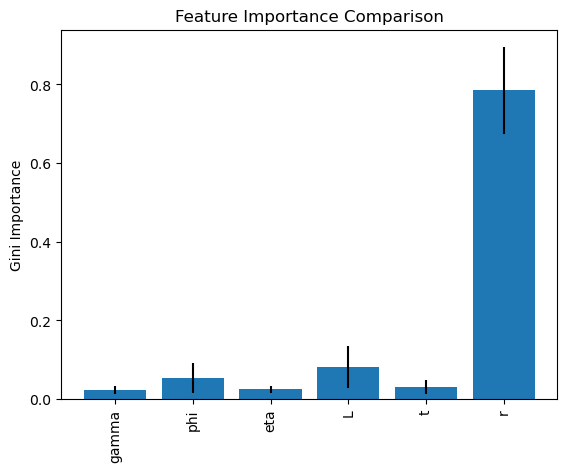

In [35]:
features_importances = biscuit_classifier.feature_importances_
features_importances_std = np.std([tree.feature_importances_ for tree in biscuit_classifier.estimators_], axis=0)

feature_names = X.columns

fig, ax = plt.subplots()
ax.bar(feature_names, features_importances, yerr=features_importances_std)
ax.set_ylabel('Gini Importance')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(feature_names, rotation=90)
ax.set_title('Feature Importance Comparison')
plt.show()

# Pore radius is the most important feature in biscuit identification!

Now to reapply this to the microscopy data

In [36]:
# Classifying the microscopy data using the trained model

untagged = pd.read_csv('microscopy-data.csv')

# removing pore size
## untagged = untagged.drop(['r'], axis=1)
scaled_X = StandardScaler().fit_transform(untagged)
y_pred = biscuit_classifier.predict(scaled_X)
untagged['y_pred'] = y_pred

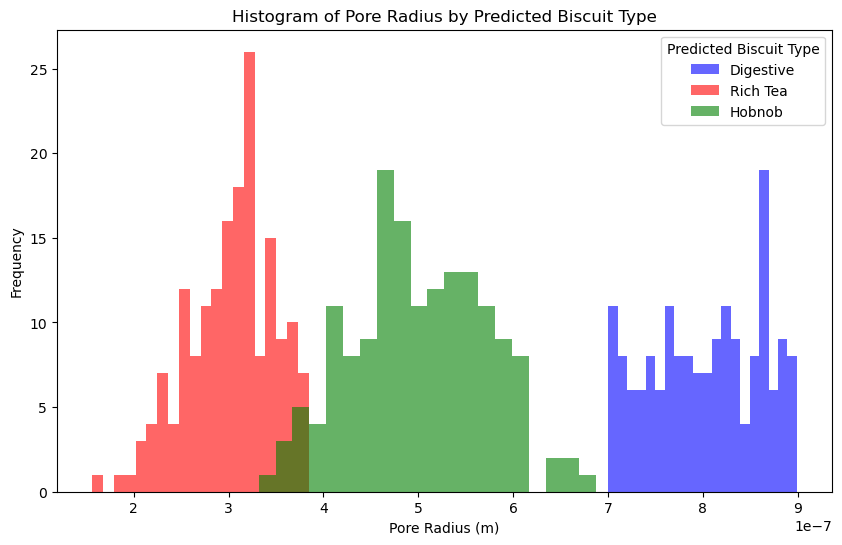

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

biscuit_types = untagged['y_pred'].unique()

# Mapping the colours onto specific biscuits so that they are the same in each chart
biscuit_colors = {
    'Digestive': 'blue',
    'Hobnob': 'green',
    'Rich Tea': 'red'
}

# Plotting histograms for each biccy type
for biscuit in biscuit_types:
    subset = untagged[untagged['y_pred'] == biscuit]
    ax.hist(subset['r'], bins=20, alpha=0.6, label=biscuit, color=biscuit_colors[biscuit])

ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Pore Radius by Predicted Biscuit Type')
ax.legend(title='Predicted Biscuit Type')

# Show the plot
plt.show()

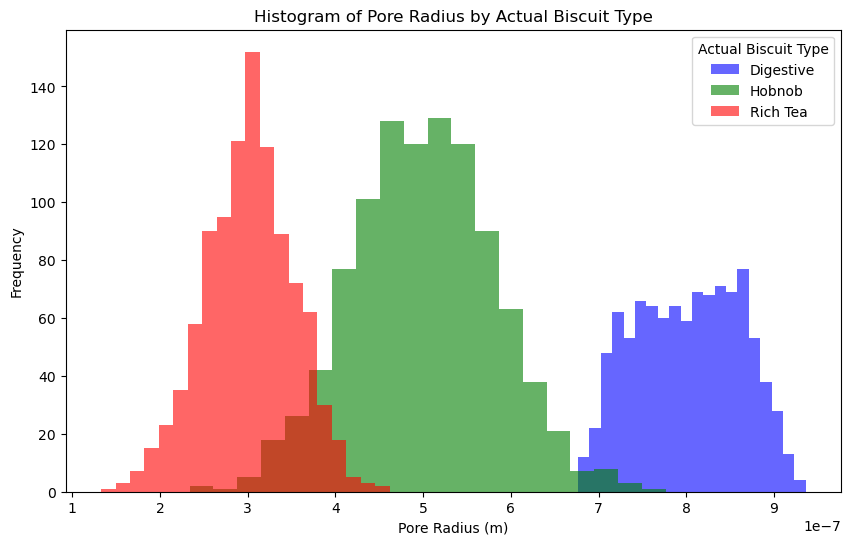

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

biscuit_types = dunk_d['biscuit'].unique()

# Plotting histograms for each biccy type
for biscuit in biscuit_types:
    subset = dunk_d[dunk_d['biscuit'] == biscuit]
    ax.hist(subset['r'], bins=20, alpha=0.6, label=biscuit, color=biscuit_colors[biscuit])

ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Pore Radius by Actual Biscuit Type')
ax.legend(title='Actual Biscuit Type')

# Show the plot
plt.show()

In [39]:
tr_all['r'] = (2 * tr_all['eta'] * tr_all['L']**2) / (tr_all['gamma'] * tr_all['t'] * np.cos(tr_all['phi']))

In [40]:
tr_all

,t,L,dL,gamma,phi,eta,r
0,30.000000,0.008087,0.000392,0.0678,1.45,0.000993,5.299585e-07
1,32.727273,0.008253,0.000270,0.0678,1.45,0.000993,5.059083e-07
2,35.454545,0.008607,0.000501,0.0678,1.45,0.000993,5.079106e-07
3,38.181818,0.008920,0.000267,0.0678,1.45,0.000993,5.066000e-07
4,40.909091,0.009604,0.000274,0.0678,1.45,0.000993,5.480791e-07
...,...,...,...,...,...,...,...
295,289.090909,0.034766,0.000118,0.0678,1.45,0.000993,1.016341e-06
296,291.818182,0.034769,0.000341,0.0678,1.45,0.000993,1.006982e-06
297,294.545455,0.034655,0.000155,0.0678,1.45,0.000993,9.911453e-07
298,297.272727,0.034646,0.000481,0.0678,1.45,0.000993,9.815560e-07


In [41]:
# Classifying the time series data using the trained model

untagged = tr_all

# removing uncertainty size
untagged = untagged.drop(['dL'], axis=1)
scaled_X = StandardScaler().fit_transform(untagged)
y_pred = biscuit_classifier.predict(scaled_X)
untagged['y_pred'] = y_pred

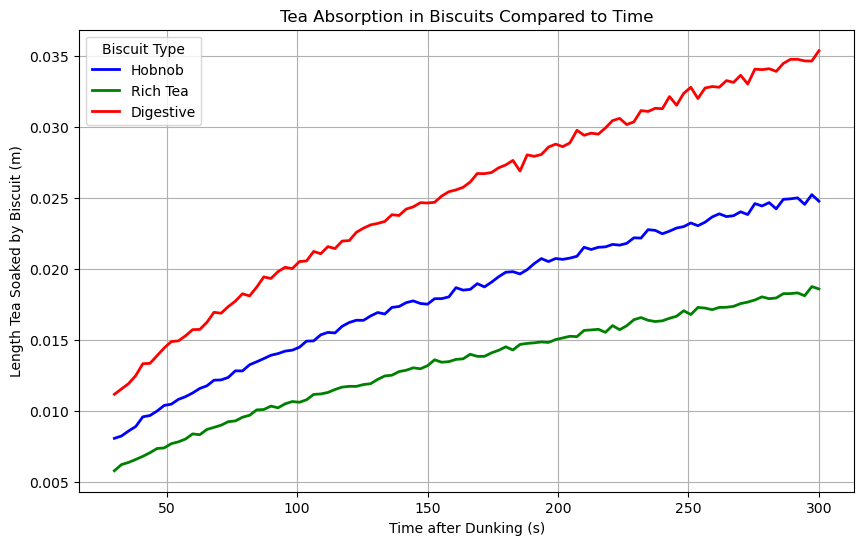

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))


biscuit_types = untagged['y_pred'].unique()
colors = ['blue', 'green', 'red']  



for biscuit, color in zip(biscuit_types, colors):
    subset = untagged[untagged['y_pred'] == biscuit]
    ax.plot(subset['t'], subset['L'], color=color, linestyle='-', linewidth=2, markersize=6, label=biscuit)

ax.set_xlabel('Time after Dunking (s)')
ax.set_ylabel('Length Tea Soaked by Biscuit (m)')
ax.set_title('Tea Absorption in Biscuits Compared to Time')

ax.legend(title='Biscuit Type')

ax.grid(True)
plt.show()

# After adding in the pore radius, the random forest model is able to predict which biscuit type each time series trial was in

### Trying to apply some unsupervised methods now

Probabilistic optimisation on the dunking-data which now has the pore size

In [43]:
dunk_d.head()

,gamma,phi,eta,L,t,biscuit,r
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,5.814437e-07


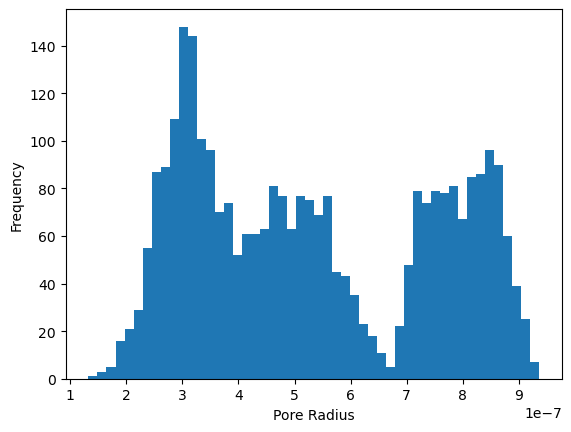

In [44]:
fig, ax = plt.subplots()
ax.hist(dunk_d['r'], bins=50)
ax.set_xlabel('Pore Radius')
ax.set_ylabel('Frequency')
plt.show()

Plotting a histogram for each biscuit type against their pore radius.



In [45]:
dunk_d.shape

(3000, 7)

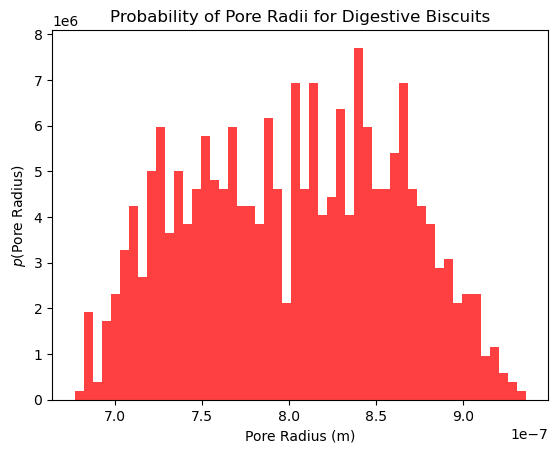

In [46]:
# Digestives:

# Create the plot
fig, ax = plt.subplots()

digestive_radii = dunk_d['r'].where(dunk_d['biscuit'] == 'Digestive')
ax.hist(digestive_radii, bins=50, density=True, color='red', alpha=0.75)

# Setting labels and title
ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('$p$(Pore Radius)')
ax.set_title('Probability of Pore Radii for Digestive Biscuits')

# Display the plot
plt.show()


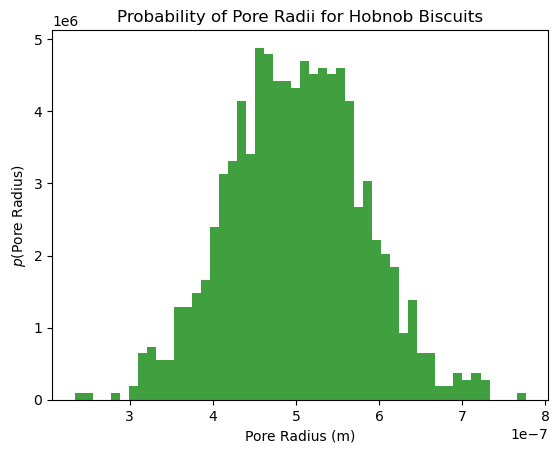

In [47]:
# Hobnobs:

# Create the plot
fig, ax = plt.subplots()

digestive_radii = dunk_d['r'].where(dunk_d['biscuit'] == 'Hobnob')
ax.hist(digestive_radii, bins=50, density=True, color='green', alpha=0.75)

# Setting labels and title
ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('$p$(Pore Radius)')
ax.set_title('Probability of Pore Radii for Hobnob Biscuits')

# Display the plot
plt.show()

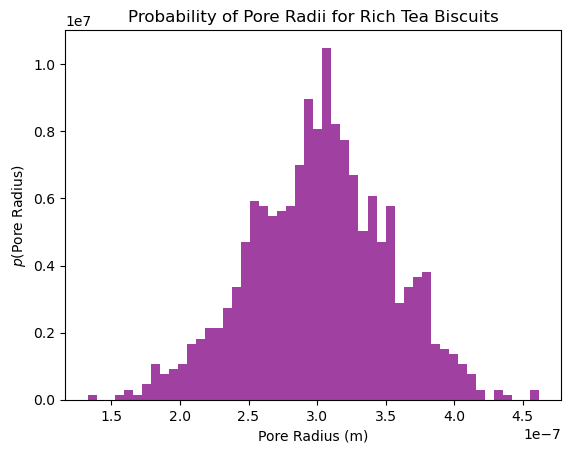

In [48]:
# Riche teas:

# Create the plot
fig, ax = plt.subplots()

digestive_radii = dunk_d['r'].where(dunk_d['biscuit'] == 'Rich Tea')
ax.hist(digestive_radii, bins=50, density=True, color='purple', alpha=0.75)

# Setting labels and title
ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('$p$(Pore Radius)')
ax.set_title('Probability of Pore Radii for Rich Tea Biscuits')

# Display the plot
plt.show()

Using density=True means that the integral of the histogram is equal to 1. Therefore, the y axis is the probability rather than the freuency so the three plots above are probability density functions (PDF).

We will now calculate the normal distributon for each biscuit and plot those with the PDF.

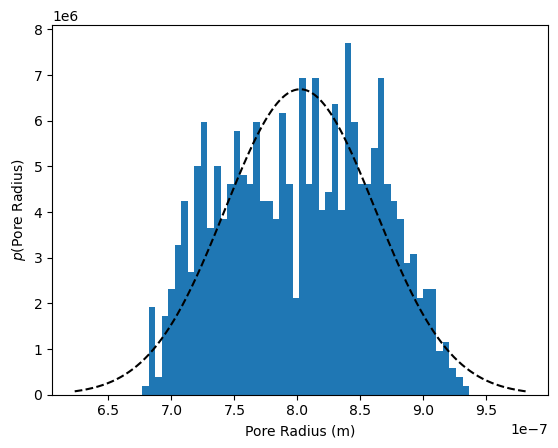

In [49]:
from scipy.stats import norm

digestive = dunk_d['r'].where(dunk_d['biscuit'] == 'Digestive')
n = norm(loc=digestive.mean(), scale=digestive.std(ddof=1))

x = np.linspace(digestive.mean() - 3 * digestive.std(ddof=1),
                digestive.mean() + 3 * digestive.std(ddof=1), 
                1000)

fig, ax = plt.subplots()
ax.hist(digestive, bins=50, density=True)
ax.plot(x, n.pdf(x), 'k--')
ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('$p$(Pore Radius)')
plt.show()

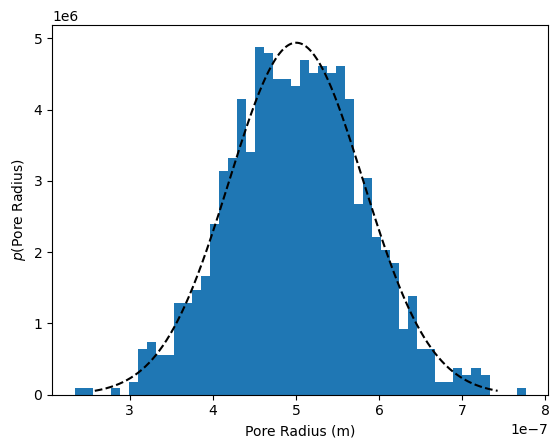

In [50]:
hobnob = dunk_d['r'].where(dunk_d['biscuit'] == 'Hobnob')
n = norm(loc=hobnob.mean(), scale=hobnob.std(ddof=1))

x = np.linspace(hobnob.mean() - 3 * hobnob.std(ddof=1),
                hobnob.mean() + 3 * hobnob.std(ddof=1), 
                1000)

fig, ax = plt.subplots()
ax.hist(hobnob, bins=50, density=True)
ax.plot(x, n.pdf(x), 'k--')
ax.set_xlabel('Pore Radius (m)')
ax.set_ylabel('$p$(Pore Radius)')
plt.show()

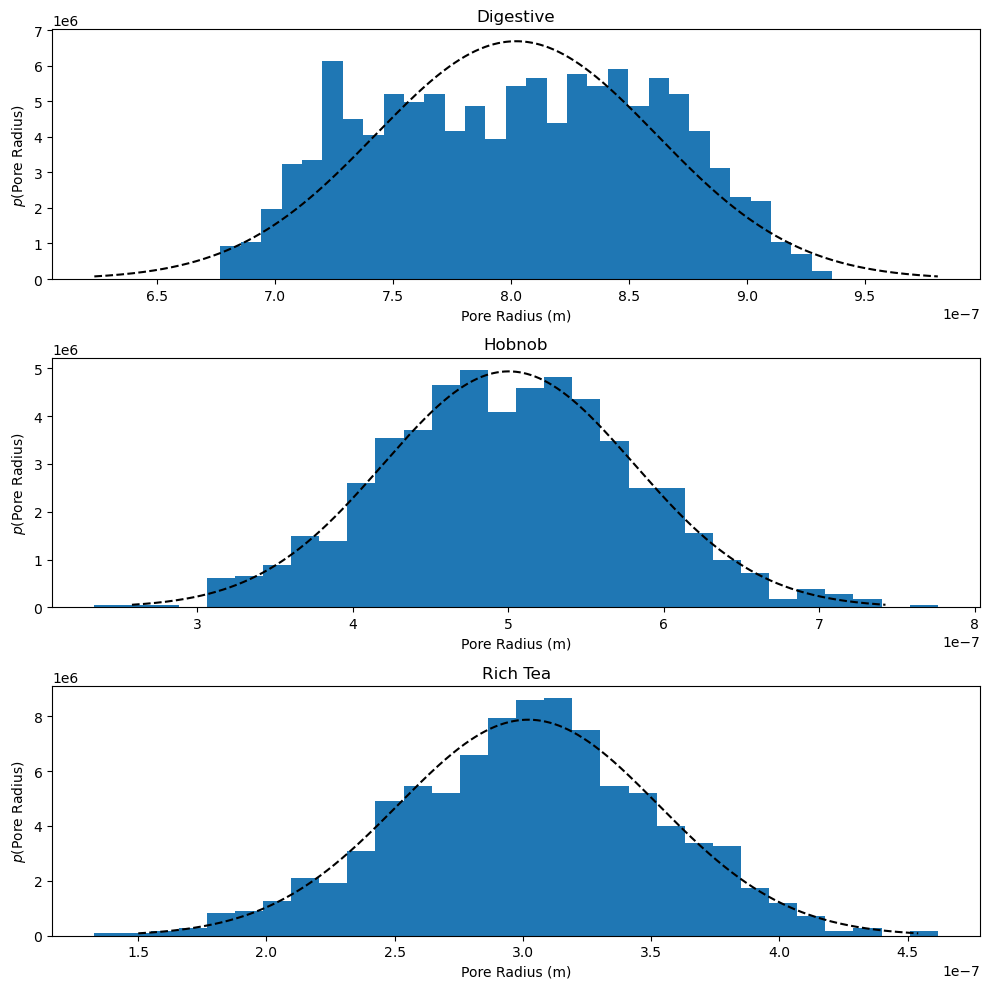

In [51]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
biscuits = ['Digestive', 'Hobnob', 'Rich Tea']
for biscuit, ax in zip(biscuits, axes.flat):
    sample = dunk_d['r'].where(dunk_d['biscuit'] == biscuit)
    n = norm(loc=sample.mean(), scale=sample.std(ddof=1))
    x = np.linspace(sample.mean() - 3 * sample.std(ddof=1),
                    sample.mean() + 3 * sample.std(ddof=1),
                    1000)
    
    ax.hist(sample, density=True, bins=30)
    ax.plot(x, n.pdf(x), 'k--')
    ax.set_xlabel('Pore Radius (m)')
    ax.set_ylabel('$p$(Pore Radius)')
    ax.set_title(biscuit)
plt.tight_layout()
plt.show()

The norm class object 'n' enables us to assess the sample distribution against the model distribution that we believe describes the true underlying population of temperatures. As the normal distribution accurately represents the true population of all the biscuit radiis, this is equivalent to performing additional measurements.

As all the samples for each biscuit type follow the same probability density function, they can be described with a single multidimensional probability density function which in this case is a multivariate normal distribution.

In [52]:
from scipy.stats import multivariate_normal

means = np.empty(len(biscuits))
vars = np.empty(len(biscuits))
lengths = np.empty(len(biscuits))
times = np.empty(len(biscuits))

for i, biscuit in enumerate(biscuits):
    sample = dunk_d['L'].where(dunk_d['biscuit'] == biscuit)
    means[i] = sample.mean()
    vars[i] = sample.var(ddof=1)
    times[i] = dunk_d['t'].where(dunk_d['biscuit'] == biscuit).mean()


means = means[np.argsort(times)]
vars = vars[np.argsort(times)]

times = np.sort(times)

mvn = multivariate_normal(mean=means, cov=np.diag(vars))

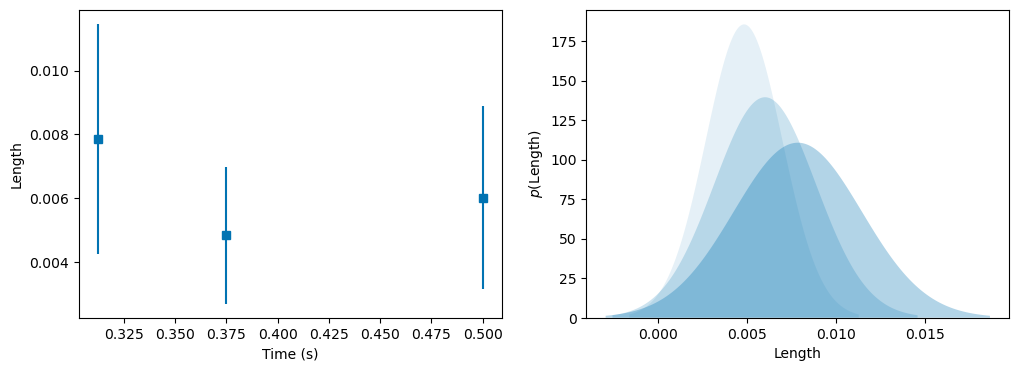

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(lengths, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Length')
for i in range(mvn.dim)[::-1]:
    x = np.linspace(mvn.mean[i] - 3 * np.sqrt(mvn.cov[i][i]), 
                   mvn.mean[i] + 3 * np.sqrt(mvn.cov[i][i]), 1000)
    ax[1].fill_between(x, norm(loc=mvn.mean[i], scale=np.sqrt(mvn.cov.diagonal()[i])).pdf(x), 
                       color='#0173B2', alpha=0.1 * i + 0.1, ec=None)
ax[1].set_ylim(0, None)
ax[1].set_xlabel('Length')
ax[1].set_ylabel('$p$(Length)')
plt.show()

In [54]:
def washburn_eqn(g, p, e, r, t):
    """
    The Washburn equation
    
    :param g: The tea surface tension (in Nm-1)
    :param p: The contact angle between the biscuit and the tea surface (in rad)
    :param e: The tea dynamic viscosity (in Pas)
    :param t: The time after initial dunking that the measurement was made (in s) -independent variable
    :param r: The radius of the pore (in m)
    
    :returns: L, the distance up the biscuit that the tea was visible (in m)
    
    """
    
    return np.sqrt((g * r * t * np.cos(p))/(2 * e))

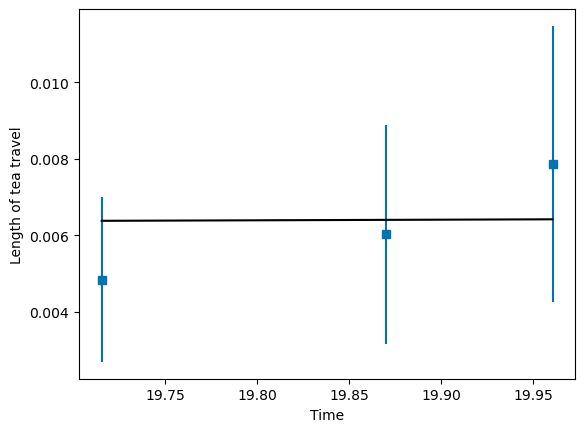

In [55]:
x = np.linspace(times.min(), times.max(), 100)

fig,ax = plt.subplots()
ax.errorbar(times, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax.plot(x, washburn_eqn(0.07, 1.5, 0.0009, 7.5e-7, x), 'k')
ax.set_xlabel('Time')
ax.set_ylabel('Length of tea travel')
plt.show()

In [56]:
from scipy.stats import multivariate_normal

means = np.empty(len(biscuits))
vars = np.empty(len(biscuits))
lengths = np.empty(len(biscuits))
radius = np.empty(len(biscuits))

for i, biscuit in enumerate(biscuits):
    sample = dunk_d['L'].where(dunk_d['biscuit'] == biscuit)
    means[i] = sample.mean()
    vars[i] = sample.var(ddof=1)
    radius[i] = dunk_d['r'].where(dunk_d['biscuit'] == biscuit).mean()


means = means[np.argsort(radius)]
vars = vars[np.argsort(radius)]

times = np.sort(radius)

mvn = multivariate_normal(mean=means, cov=np.diag(vars))

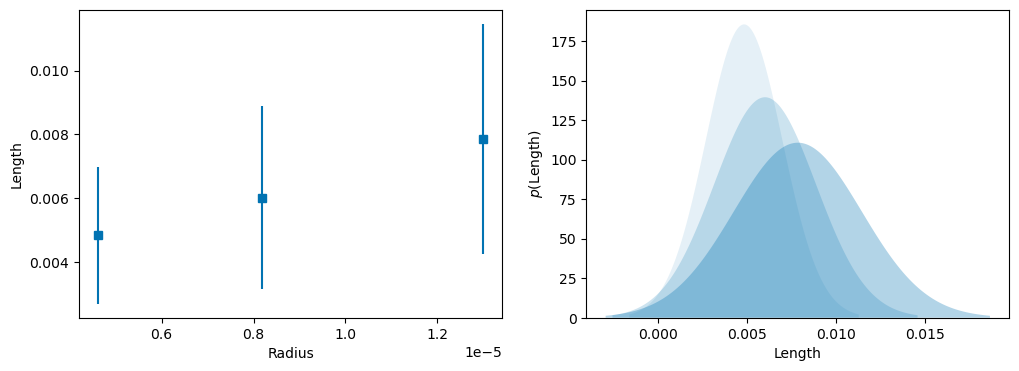

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(lengths, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax[0].set_xlabel('Radius')
ax[0].set_ylabel('Length')
for i in range(mvn.dim)[::-1]:
    x = np.linspace(mvn.mean[i] - 3 * np.sqrt(mvn.cov[i][i]), 
                   mvn.mean[i] + 3 * np.sqrt(mvn.cov[i][i]), 1000)
    ax[1].fill_between(x, norm(loc=mvn.mean[i], scale=np.sqrt(mvn.cov.diagonal()[i])).pdf(x), 
                       color='#0173B2', alpha=0.1 * i + 0.1, ec=None)
ax[1].set_ylim(0, None)
ax[1].set_xlabel('Length')
ax[1].set_ylabel('$p$(Length)')
plt.show()

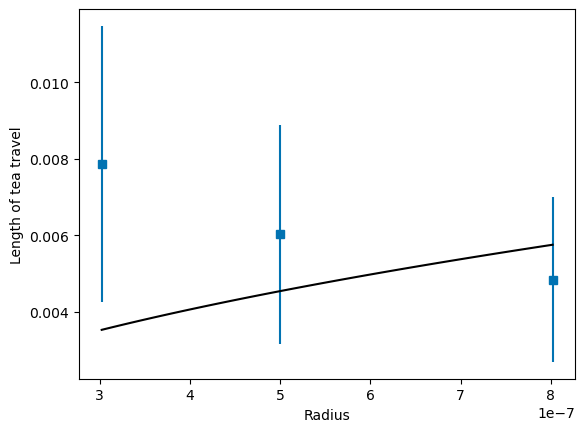

In [58]:
x = np.linspace(radius.min(), radius.max(), 100)

fig,ax = plt.subplots()
ax.errorbar(radius, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax.plot(x, washburn_eqn(0.07, 1.5, 0.0009, x, 15), 'k')
ax.set_xlabel('Radius')
ax.set_ylabel('Length of tea travel')
plt.show()

Need to try and optimise this. The probability can be found for a given probability distribution with the following function:

In [59]:
mvn.logpdf(washburn_eqn(0.07, 1.5, 0.0009, radius, 15))

13.921552366295384

We want to maximmise this logpdf by changing the values of g, p, e, and t. We need to produce a negative log-likelihood function (nll)

In [60]:
def nll(g):
    """
    :param g: The parameters being optimised.
    :returns: The negative log PDF value.
    """
    return -mvn.logpdf(washburn_eqn(radius, *g))

In [61]:
from scipy.optimize import minimize

In [62]:
result = minimize(nll, [0.08, 0.8, 0.001, 20])
result

C:\Users\rache\anaconda3\envs\deepchem24\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
C:\Users\rache\anaconda3\envs\deepchem24\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


      fun: -12.471306847460273
 hess_inv: array([[ 1.00000020e+00,  3.11636050e-06, -1.20522253e-03,
        -1.24552449e-07],
       [ 3.11636050e-06,  1.00004865e+00, -1.88435021e-02,
        -1.94459252e-06],
       [-1.20522253e-03, -1.88435021e-02,  1.07873433e-02,
         7.52468544e-04],
       [-1.24552449e-07, -1.94459252e-06,  7.52468544e-04,
         1.00000008e+00]])
      jac: array([ 0.12450278,  1.94624913, -1.53762937, -0.07772684])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 79
      nit: 1
     njev: 14
   status: 2
  success: False
        x: array([ 0.07991903,  0.7987375 ,  1.01099921, 20.0000505 ])

Receiving errors when running with the washburn equation due to trying to sqrt a negtive number, so going to change the washburn equation to be L squared

In [63]:
def washburn_eqn_sq(g, p, e, r, t):
    """
    The Washburn equation
    
    :param g: The tea surface tension (in Nm-1)
    :param p: The contact angle between the biscuit and the tea surface (in rad)
    :param e: The tea dynamic viscosity (in Pas)
    :param t: The time after initial dunking that the measurement was made (in s) -independent variable
    :param r: The radius of the pore (in m)
    
    :returns: L^2, the distance up the biscuit that the tea was visible squared (in m)
    
    """

    return (g * r * t * np.cos(p))/(2 * e)

In [64]:
def nll(g):
    """
    :param g: The parameters being optimised.
    :returns: The negative log PDF value.
    """
    return -mvn.logpdf(washburn_eqn_sq(radius, *g))

In [65]:
result = minimize(nll, [0.08, 0.8, 0.001, 20])
result

      fun: -13.209531578122302
 hess_inv: array([[ 9.99493997e-01, -2.25928498e-02, -3.41775248e-01,
         4.70910166e-04],
       [-2.25928498e-02,  3.45807955e-02,  1.60227102e+01,
         2.02387746e-02],
       [-3.41775248e-01,  1.60227102e+01,  1.31513658e+04,
        -4.53952954e-02],
       [ 4.70910166e-04,  2.02387746e-02, -4.53952954e-02,
         9.99571525e-01]])
      jac: array([ 0.0000000e+00,  5.7220459e-06,  0.0000000e+00, -1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 85
      nit: 5
     njev: 17
   status: 0
  success: True
        x: array([5.41240019e-02, 3.94554467e-01, 3.10729164e+02, 2.00151951e+01])

In [66]:
result.x

array([5.41240019e-02, 3.94554467e-01, 3.10729164e+02, 2.00151951e+01])

Need to add a column of L^2 into the dataframe

In [67]:
dunk_d['L2'] = dunk_d['L'] ** 2

In [68]:
means = np.empty(len(biscuits))
vars = np.empty(len(biscuits))
lengths2 = np.empty(len(biscuits))
radius = np.empty(len(biscuits))

for i, biscuit in enumerate(biscuits):
    sample = dunk_d['L2'].where(dunk_d['biscuit'] == biscuit)
    means[i] = sample.mean()
    vars[i] = sample.var(ddof=1)
    radius[i] = dunk_d['r'].where(dunk_d['biscuit'] == biscuit).mean()


means = means[np.argsort(radius)]
vars = vars[np.argsort(radius)]

times = np.sort(radius)

mvn = multivariate_normal(mean=means, cov=np.diag(vars))

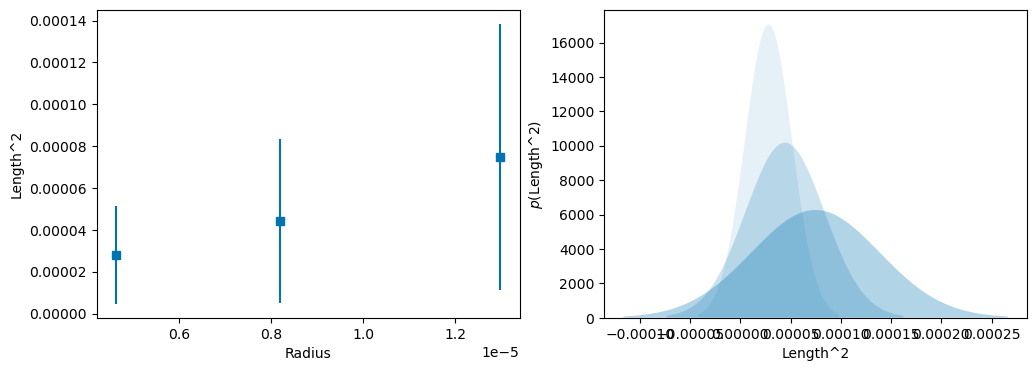

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(lengths2, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax[0].set_xlabel('Radius')
ax[0].set_ylabel('Length^2')
for i in range(mvn.dim)[::-1]:
    x = np.linspace(mvn.mean[i] - 3 * np.sqrt(mvn.cov[i][i]), 
                   mvn.mean[i] + 3 * np.sqrt(mvn.cov[i][i]), 1000)
    ax[1].fill_between(x, norm(loc=mvn.mean[i], scale=np.sqrt(mvn.cov.diagonal()[i])).pdf(x), 
                       color='#0173B2', alpha=0.1 * i + 0.1, ec=None)
ax[1].set_ylim(0, None)
ax[1].set_xlabel('Length^2')
ax[1].set_ylabel('$p$(Length^2)')
plt.show()

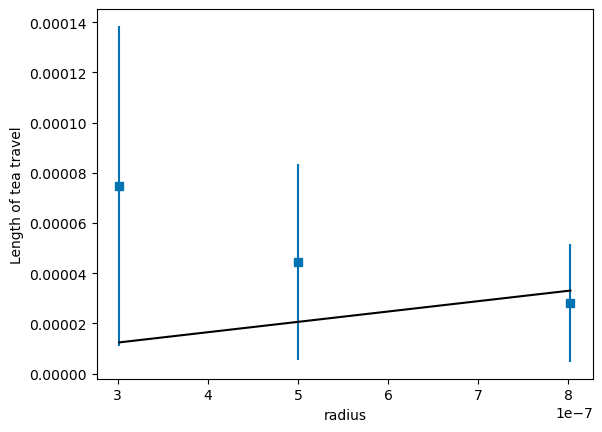

In [70]:
x = np.linspace(radius.min(), radius.max(), 100)

fig,ax = plt.subplots()
ax.errorbar(radius, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax.plot(x, washburn_eqn_sq(0.07, 1.5, 0.0009, x, 15), 'k')
ax.set_xlabel('radius')
ax.set_ylabel('Length of tea travel')
plt.show()

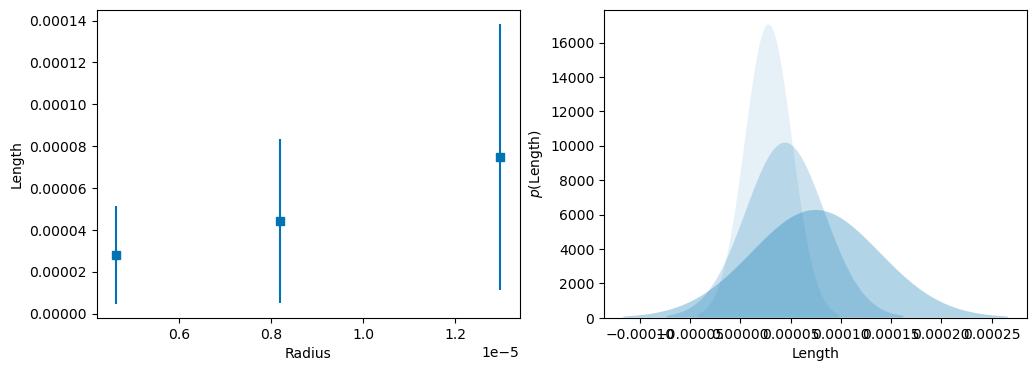

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(lengths2, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax[0].set_xlabel('Radius')
ax[0].set_ylabel('Length')
for i in range(mvn.dim)[::-1]:
    x = np.linspace(mvn.mean[i] - 3 * np.sqrt(mvn.cov[i][i]), 
                   mvn.mean[i] + 3 * np.sqrt(mvn.cov[i][i]), 1000)
    ax[1].fill_between(x, norm(loc=mvn.mean[i], scale=np.sqrt(mvn.cov.diagonal()[i])).pdf(x), 
                       color='#0173B2', alpha=0.1 * i + 0.1, ec=None)
ax[1].set_ylim(0, None)
ax[1].set_xlabel('Length')
ax[1].set_ylabel('$p$(Length)')
plt.show()

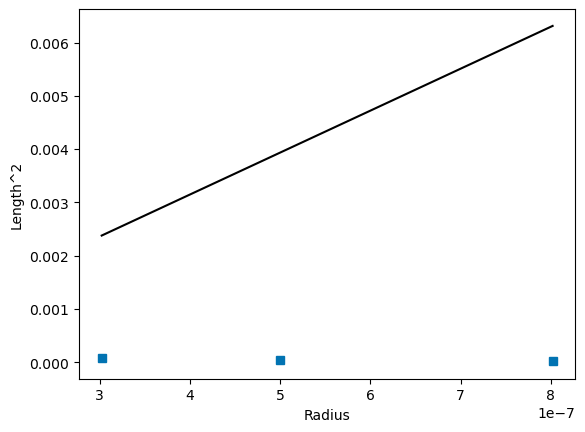

In [72]:
x = np.linspace(radius.min(), radius.max(), 100)

fig, ax = plt.subplots()
ax.errorbar(radius, mvn.mean, np.sqrt(mvn.cov.diagonal()), ls='', marker='s', color='#0173B2')
ax.plot(x, washburn_eqn_sq(x, *result.x), 'k')
ax.set_xlabel('Radius')
ax.set_ylabel('Length^2')
plt.show()